# **Imports**

In [16]:
import itertools
import cv2
import os
import time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7  as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from glob import glob

# **Data Preparation**

In [17]:
# Copying the folders into a single folder
!mkdir ./LungColon

print('Copying files...')
!cp -R ../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/* ./LungColon
!cp -R ../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/* ./LungColon
print('All files copied successfully!')

mkdir: cannot create directory ‘./LungColon’: File exists
Copying files...
^C
All files copied successfully!


In [18]:
folders = glob('./LungColon' + '/*')
print('New Paths: ', folders)

IMAGE_FILES = glob('./LungColon' + '/*/*.jpeg')
print('Images Count: ', len(IMAGE_FILES))

New Paths:  ['./LungColon/lung_aca', './LungColon/colon_n', './LungColon/colon_aca', './LungColon/lung_scc', './LungColon/lung_n']
Images Count:  25000


# **Showing Sample Images**

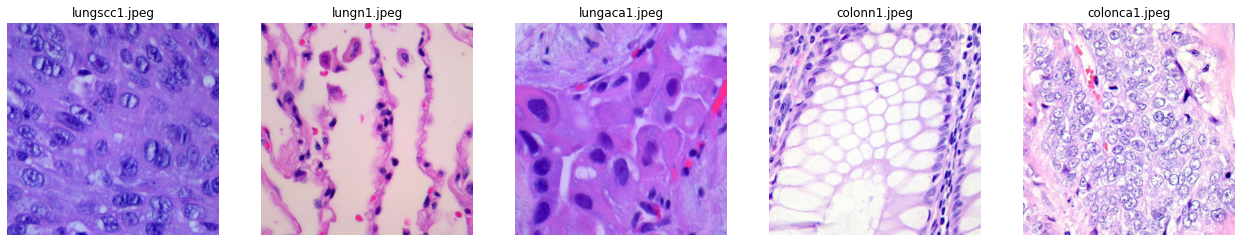

In [19]:
SAMPLES = ['./LungColon/lung_scc/lungscc1.jpeg', './LungColon/lung_n/lungn1.jpeg', 
           './LungColon/lung_aca/lungaca1.jpeg', './LungColon/colon_n/colonn1.jpeg', 
           './LungColon/colon_aca/colonca1.jpeg']

plt.figure(figsize=(22, 8)) 
global c
c = 0

for i in SAMPLES:
    plt.subplot(1, 5, c + 1)
    c += 1
    t = i.split('/')
    plt.title(t[3])
    plt.imshow(image.load_img(i))
    plt.axis('off')
plt.show()

# **Generating Data**

In [21]:
data_dir = './LungColon'

# 80-20 Split
data = ImageDataGenerator(validation_split = 0.2)

BATCH_SIZE = 128

# 224 x 224 -- The minimum for EfficientNetB7, you can go as high as 600 x 600
X = Y = 224

training = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

validation = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [25]:
base_model = MobileNet(include_top =False, weights = 'imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(training.num_classes, activation='softmax')(x)
model = Model (inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
history= model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy' ])
model.fit(
training,
epochs = 10)

Epoch 1/10
157/157 [==============================] - 180s 1s/step - loss: 1.3127 - accuracy: 0.6787
Epoch 2/10
157/157 [==============================] - 179s 1s/step - loss: 0.4388 - accuracy: 0.8199
Epoch 3/10
157/157 [==============================] - 179s 1s/step - loss: 0.3502 - accuracy: 0.8568
Epoch 4/10
157/157 [==============================] - 180s 1s/step - loss: 0.3023 - accuracy: 0.8813
Epoch 5/10
157/157 [==============================] - 181s 1s/step - loss: 0.2543 - accuracy: 0.8975
Epoch 6/10
157/157 [==============================] - 181s 1s/step - loss: 0.2319 - accuracy: 0.9069
Epoch 7/10
157/157 [==============================] - 180s 1s/step - loss: 0.3753 - accuracy: 0.8497
Epoch 8/10
157/157 [==============================] - 181s 1s/step - loss: 0.2207 - accuracy: 0.9146
Epoch 9/10
157/157 [==============================] - 182s 1s/step - loss: 0.2040 - accuracy: 0.9180
Epoch 10/10
157/157 [==============================] - 181s 1s/step - loss: 0.2192 - accura

# **Classification Report**

In [31]:
test_loss,test_acc = model.evaluate(validation, verbose = 2)
print("\nTest accuracy: ", test_acc)

40/40 - 47s - loss: 0.1884 - accuracy: 0.9290

Test accuracy:  0.9290000200271606


In [32]:
model.save('/kaggle/working/colon_lung.h5')

In [33]:
from sklearn.metrics import classification_report

Y_pred = model.predict(validation)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(validation.classes, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1000
           1       0.93      0.98      0.96      1000
           2       0.94      0.80      0.86      1000
           3       0.99      0.98      0.99      1000
           4       0.84      0.95      0.89      1000

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



# **Confusion Matrix**

Normalized confusion matrix


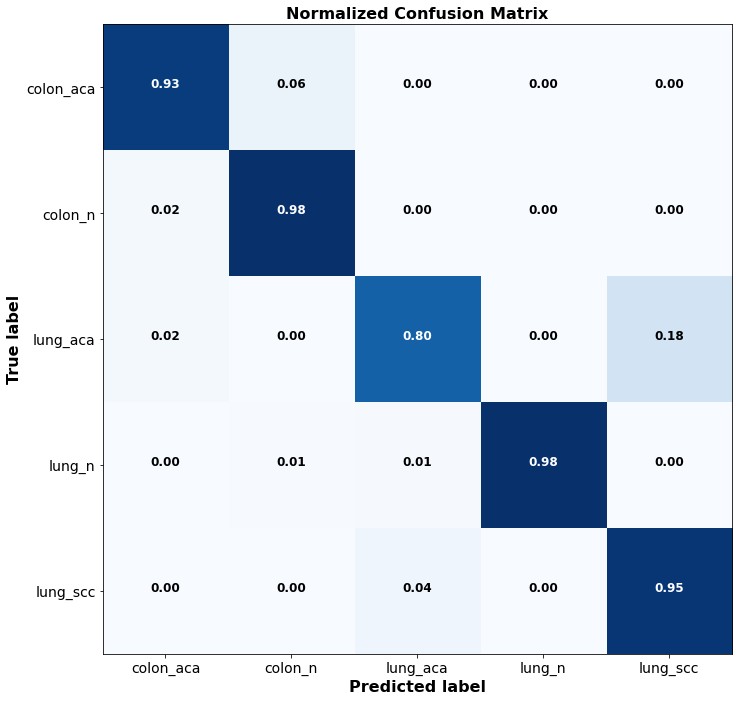

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(validation.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()